# Pivot irrigators problem

This example is based on this post: https://www.solvermax.com/blog/pivot-irrigators-in-a-100-acre-field.

## Introduction

We consider the optimization of the layout of centre-pivot irrigation machines in a field, that can be modeled as a circle packing problem.

Pivot irrigators are commonly used by crop farmers to supplement natural rainfall. For example, large areas of the mid-west USA are covered with these machines. The machines are almost always arranged in a simple grid pattern, which is not an efficient design in terms of coverage.

We consider the following situation:
- In a semi-arid region, only irrigated areas are productive.
- We consider a rectangular field in this region, with sides of 914.400 by 442.570 metres, with a total area of 40.4686 hectares (exactly 100 acres).
- The water distribution system of the field, composed of pivot irrigators, is worn out, so we need to replace it with the same type of machines.
- The machines are composed of a pivot mechanism and 20 metre long segments.

To maximize crop yield, it is important that we irrigate as much of the area as possible. However, we need to account for the cost of the machines, along with the operational and maintenance costs over their lifetime.

<div style="text-align: center;">
    <img src="simple_grid_pattern_8_machines.png" alt="Arrow" style="width: 700; height: auto;">
</div>
<div style="text-align: center;">
    <img src="arrow.png" alt="Arrow" style="width: 100px; height: auto;">
</div>
<div style="text-align: center;">
    <img src="optimal_layout_8_machines.png" alt="Arrow" style="width: 700px; height: auto;">
</div>

## Investment characteristics

Each machine costs \\$43,606 to purchase, install and for it's maintenance over 15 years (its expected lifetime). A machine consists of the pivot mechanism and a single 20 metre long built-in segment.
Additional 20 metre long segments cost \\$15,803 each all included. A machine may have up to a total of eight segments (including the built-in segment).

We have fixed operating costs of \\$2,009,098 for 15 years, covering costs for other machinery and staff associated with working the field.

The planned crop will yield an average gross margin of \\$10.268 per square metre per year, allowing for all variable costs (planting, harvesting, etc).

A positive Net Present Value (NPV) would indicate that this is a worthwhile investment, while whith a negative one, the investment is a loss.


Furthermore, we note that larger machines are more profitable. Specifically, the cost of a machine is a linear function of the number of segments. But the yield from a machine is a function of the coverage area, which increases with the square of the number of segments. Therefore, all else being equal, larger machines are better.

As well, a machine with only one or two segments makes a loss, while larger machines make a positive contribution to the NPV. Therefore, we need to consider only machines with at least 3 segments (including the built-in segment).

## Problem description

**Input**
* $S_{\text{size}}$ the length of each irrigation machine segment
* $S^{\text{min}}$ the minimum number of segments per machine
* $S^{\text{max}}$ the maximum number of segments per machine
* $W$ the width of the field
* $L$ the length of the field
* $C_{\text{operating}}$ the operating cost (over 15 years)
* $C_{\text{machine}}$ the cost of each irrigation machine (all included)
* $C_{\text{segment}}$ the cost of each irrigation machine segment (all included)
* $Y$ the yield per square meter irrigated

**Problem**:

Create a layout by choosing:
* the number of machines
* the number of segments of each machine
* the position of each machine in the field

Such that:
- the circle covered by each machine is within the field's boundaries
- two machines' pivot's circles cannot overlap

**Objective**:

Maximize the overall NPV of our investment.


This is a variant of a circle packing problem, where the radii of the circles are decisions and must take values in a discrete set of values. 

## Mixed-integer nonlinear model

We simplify the model by making the number of machines an exogenous input $N$. Otherwise, we should have additionnal variables for each machine to decide if we use it or not, which would unnecessarily complicate the model.

Our model needs to decide, for each machine, the number of segments and the position of each machine's pivot.
We can then look iteratively at a reasonable range for the number of machines.

**Variables**

* $s_i \in \mathbb{N}$, $S^\text{min} \le s_i \le S^\text{max}$, $i=1,...,N$, the number of segments of the machine $i$ (including the built-in segment)
* $x_i\in \mathbb{R}$, $i=1,...,N$, the $x$ position of the machine $i$ 's centre
* $y_i\in \mathbb{R}$, $i=1,...,N$, the $y$ position of the machine $i$ 's centre

**Objective**: maximize the NPV, deducting the costs from the machines and the additional segments, and the operating cost

$$\left( \sum_{i=1}^N\pi \cdot(S_{\text{size}}\cdot s_i)^2\right) \cdot Y -N \cdot C_{\text{machine}} -\left( \sum_{i=1}^N (s_i -1)\right) \cdot C_{\text{segment}} - C_{\text{operating}}$$

Note that the NPV calculation is linear. But yield is a function of the area covered by each machine. The area depends on the squared number of segments in each machine, which is non-linear.

**Constraints**

- Irrigation circles are within the field's boundaries:

$$\forall i=1,...,N, \qquad 0\leq x_i- S_{\text{size}}\cdot s_i$$
$$\forall i=1,...,N, \qquad x_i+S_{\text{size}}\cdot s_i\leq W$$
$$\forall i=1,...,N, \qquad 0\leq y_i- S_{\text{size}}\cdot s_i$$
$$\forall i=1,...,N, \qquad y_i+S_{\text{size}}\cdot s_i\leq L$$

- Irrigation circles must not overlap:

$$\forall i,j=1,...,N, \qquad (x_i-x_j)^2+(y_i-y_j)^2\geq (S_{\text{size}}\cdot s_i + S_{\text{size}}\cdot s_j)^2$$

## Model implementation

First, let's define the input data.

In [ ]:
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Situation
OPERATING_COST = 2009098  # $ for 15 annum, real
WIDTH = 914.400  # Field width, meters
LENGTH = 442.570  # Field length, meters
SEGMENT_LENGTH = 20  # Length of a machine segment, meters
MACHINE_COST = 43606  # Cost of the machine, including built-in segments, $
SEGMENT_COST = 15803  # Cost of additional segments, $
SEGMENTS_MIN = 3  # Minimum number of segments, including built-in segments
SEGMENTS_MAX = 8  # Maximum number of segments, including built-in segments
YIELD_GROSS = 10.268  # Gross yield of crop, $ per square metre per year, real

Now, let's implement the model with Pyomo.

In [2]:
def create_model(MACHINES):
    model = pyo.ConcreteModel()

    ####################
    # Create variables #
    ####################

    model.Machines = pyo.RangeSet(0, MACHINES - 1)

    # Number of segments, including built-in
    model.segment = pyo.Var(
        model.Machines, within=pyo.Integers, bounds=(SEGMENTS_MIN, SEGMENTS_MAX)
    )
    # x center of machine
    model.x = pyo.Var(
        model.Machines,
        bounds=(SEGMENTS_MIN * SEGMENT_LENGTH, WIDTH - SEGMENTS_MIN * SEGMENT_LENGTH),
    )
    # y center of machine
    model.y = pyo.Var(
        model.Machines,
        bounds=(SEGMENTS_MIN * SEGMENT_LENGTH, LENGTH - SEGMENTS_MIN * SEGMENT_LENGTH),
    )

    #############
    # Objective #
    #############

    # NPV of pivot irrigator investment
    def objective_rule(model):
        yield_tot = (
            sum(
                np.pi * (model.segment[m] * SEGMENT_LENGTH) ** 2 for m in model.Machines
            )
            * YIELD_GROSS
        )
        cost_machines = MACHINES * MACHINE_COST
        cost_segments = (
            sum((model.segment[m] - 1) for m in model.Machines) * SEGMENT_COST
        )
        return yield_tot - cost_machines - cost_segments - OPERATING_COST

    model.obj = pyo.Objective(rule=objective_rule, sense=pyo.maximize)

    ###############
    # Constraints #
    ###############

    # Irrigation circles are within the field's boundaries
    def x_lb_rule(model, m):
        return model.x[m] >= model.segment[m] * SEGMENT_LENGTH

    model.x_lb = pyo.Constraint(model.Machines, rule=x_lb_rule)

    def x_ub_rule(model, m):
        return model.x[m] <= WIDTH - model.segment[m] * SEGMENT_LENGTH

    model.x_ub = pyo.Constraint(model.Machines, rule=x_ub_rule)

    def y_lb_rule(model, m):
        return model.y[m] >= model.segment[m] * SEGMENT_LENGTH

    model.y_lb = pyo.Constraint(model.Machines, rule=y_lb_rule)

    def y_ub_rule(model, m):
        return model.y[m] <= LENGTH - model.segment[m] * SEGMENT_LENGTH

    model.y_ub = pyo.Constraint(model.Machines, rule=y_ub_rule)

    # Irrigation circles must not overlap
    def no_overlap_rule(model, m, n):
        if m > n:
            return (model.x[m] - model.x[n]) ** 2 + (model.y[m] - model.y[n]) ** 2 >= (
                model.segment[m] * SEGMENT_LENGTH + model.segment[n] * SEGMENT_LENGTH
            ) ** 2
        return pyo.Constraint.Skip

    model.no_overlap = pyo.Constraint(
        model.Machines, model.Machines, rule=no_overlap_rule
    )

    return model

## Resolution for the case with 8 machines

Let's start by solving the case with 8 machines.

In [ ]:
# Solve with Knitro.
solver = pyo.SolverFactory("knitroampl")
solver.options["mip_multistart"] = 1
solver.options["mip_maxnodes"] = 27000

MACHINES = 8
model = create_model(MACHINES)

print(f"Machines: {MACHINES}\n")
result = solver.solve(model, tee=True)

And visualize the output.


Solution with 8 machines:
-------------------

Objective: 353,446

Machine  0: x =  454.130, y =  282.570, segments =   8
Machine  1: x =  639.247, y =  100.000, segments =   5
Machine  2: x =  268.888, y =  100.053, segments =   5
Machine  3: x =   84.735, y =   84.735, segments =   4
Machine  4: x =  772.926, y =  301.096, segments =   7
Machine  5: x =  830.804, y =   83.596, segments =   4
Machine  6: x =  481.593, y =   62.137, segments =   3
Machine  7: x =  140.000, y =  302.570, segments =   7



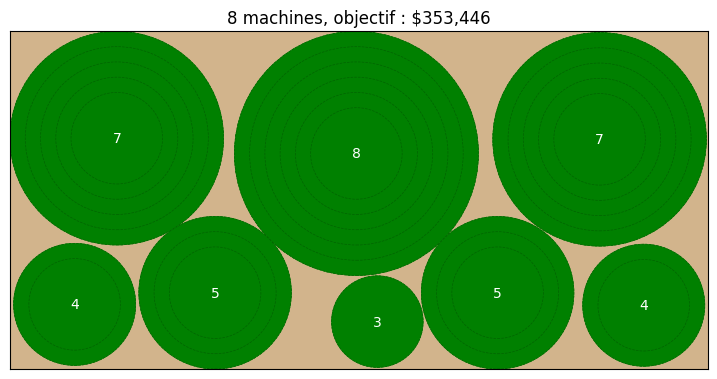

In [ ]:
def show_solution(
    model, MACHINES, axe
):  # Show the field with the irrigator machine solution
    for i in range(MACHINES):
        circle = plt.Circle(
            (model.x[i](), model.y[i]()),
            model.segment[i]() * SEGMENT_LENGTH,
            color="green",
            fill=True,
            linewidth=0.5,
        )
        axe.add_artist(circle)
        for l in range (3,int(model.segment[i]())+1):
            circle_dot = plt.Circle(
                (model.x[i](), model.y[i]()),
                l * SEGMENT_LENGTH,
                edgecolor="darkgreen",
                facecolor="none",
                linestyle="--",
                linewidth=0.5
            )
            axe.add_artist(circle_dot)
        axe.text(
            model.x[i](),
            model.y[i](),
            f"{model.segment[i]():.0f}",
            color="white",
            fontsize=10,
            ha="center",
            va="center",
        )
    axe.set_xlim((0, WIDTH))
    axe.set_ylim((0, LENGTH))
    axe.set_aspect("equal", adjustable="box")
    axe.set_facecolor("tan")  # Set plot area background
    axe.set_xticks([])  # Remove axis labels and tick marks
    axe.set_yticks([])
    axe.set_xlabel("")
    axe.set_ylabel("")
    axe.set_title(f"{MACHINES} machines, objectif : ${model.obj():,.0f}")


def print_results(model, MACHINES, axe):
    print()
    print(f"Solution with {MACHINES} machines:")
    print("-------------------")
    print(f"\nObjective: {model.obj():,.0f}\n")
    for i in range(MACHINES):
        print(
            f"Machine {i:>2}: x = {model.x[i]():>8,.3f}, y = {model.y[i]():>8,.3f}, segments = {model.segment[i]():>3,.0f}"
        )
    show_solution(model, MACHINES, axe)


_, axe = plt.subplots(figsize=(9, 6))
print_results(model, MACHINES, axe)
plt.show()

## Resolution for each number of machines

Now let's solve the problem for each number of machines.

Machines: 3

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

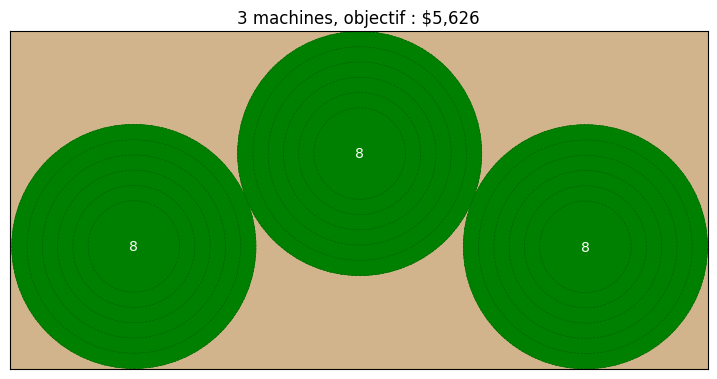

Machines: 4

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

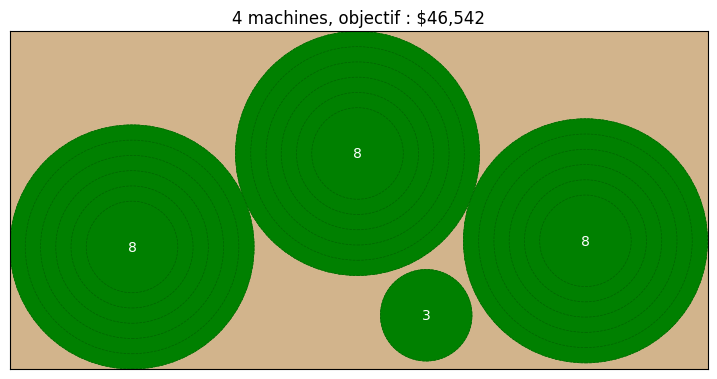

Machines: 5

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

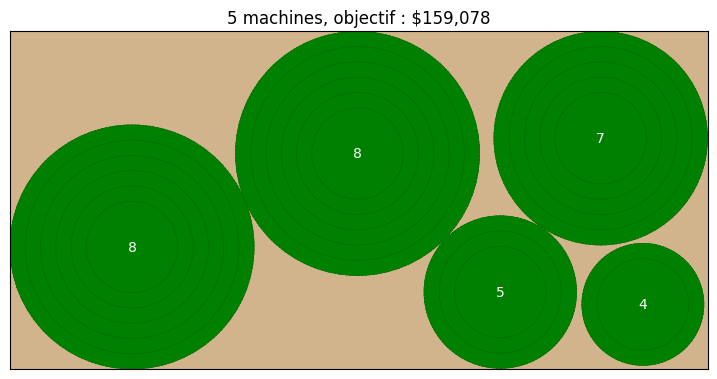

Machines: 6

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

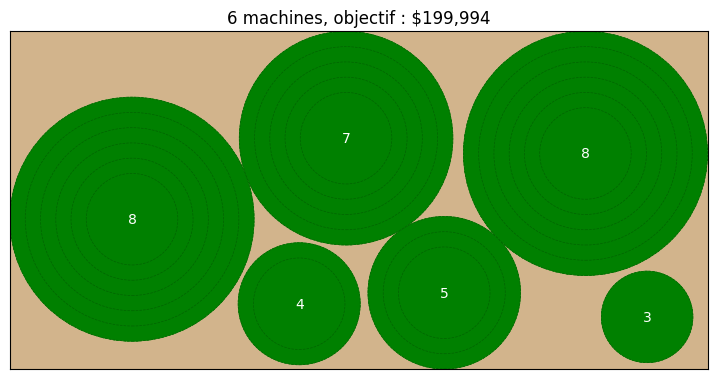

Machines: 7

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

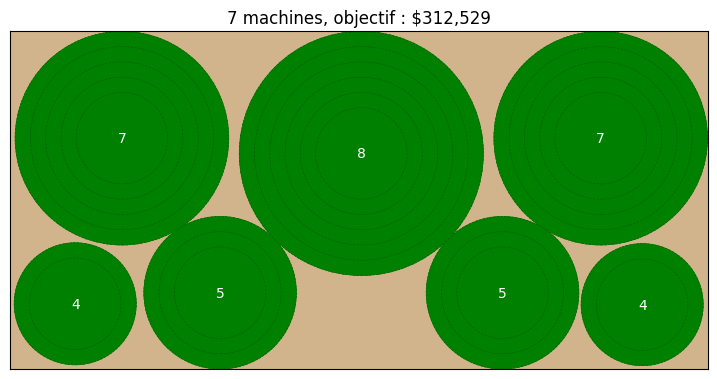

Machines: 8

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

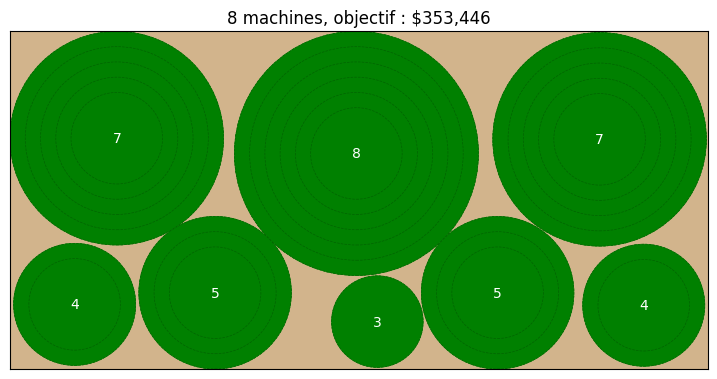

Machines: 9

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro chan

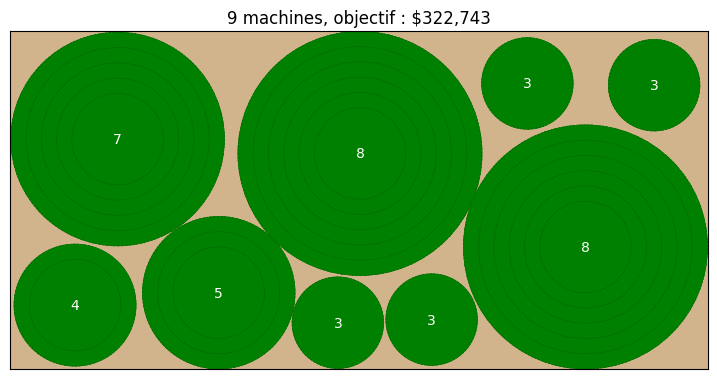

Machines: 10

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro cha

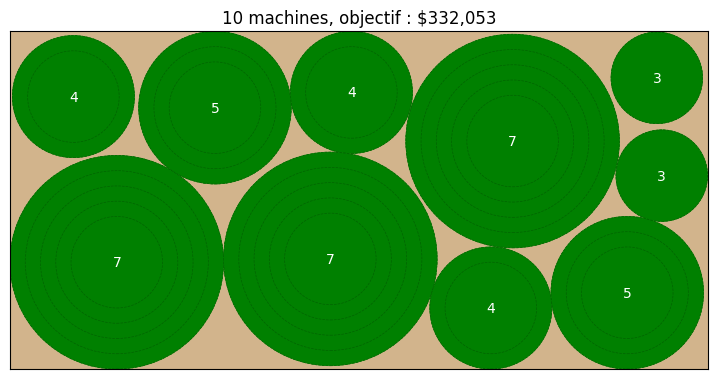

Machines: 11

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro cha

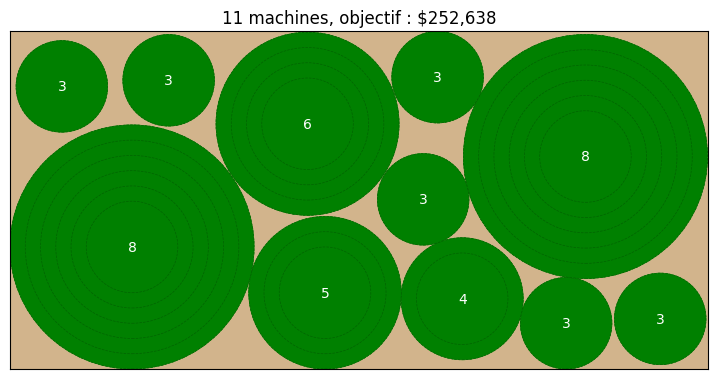

Machines: 12

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro cha

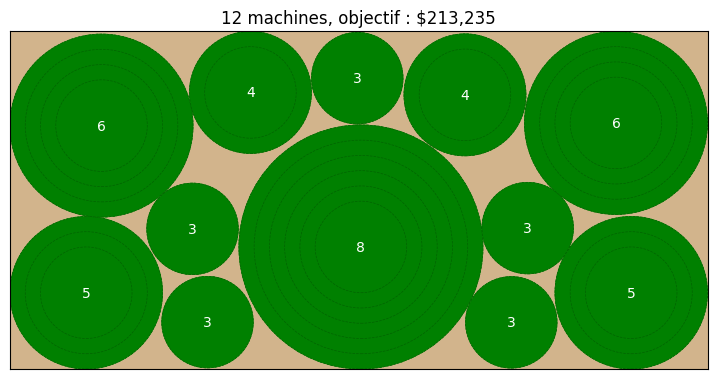

Machines: 13

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro cha

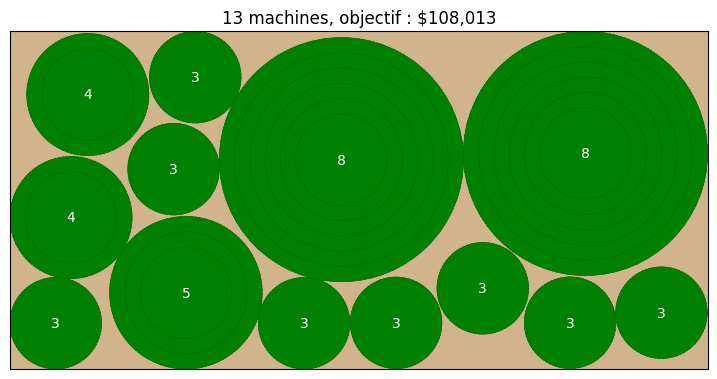

Machines: 14

Artelys Knitro 15.0.0: mip_multistart=1
mip_maxnodes=27000

          Commercial License
         Artelys Knitro 15.0.0

No start point provided -- Knitro computing one.

concurrent_evals         0
datacheck                0
feastol                  1e-06
feastol_abs              1e-06
findiff_numthreads       1
hessian_no_f             1
hessopt                  1
mip_maxnodes             27000
mip_multistart           1
opttol                   1e-06
opttol_abs               0.001
The problem is identified as a MIQCQP.
Knitro changing mip_method from AUTO to 1.
Knitro changing mip_root_nlpalg from AUTO to 1.
Knitro changing mip_branchrule from AUTO to 2.
Knitro changing mip_selectrule from AUTO to 2.
Knitro changing mip_mir from AUTO to 2.
Knitro changing mip_clique from AUTO to 0.
Knitro changing mip_zerohalf from AUTO to 0.
Knitro changing mip_liftproject from AUTO to 0.
Knitro changing mip_knapsack from AUTO to 2.
Knitro changing mip_gomory from AUTO to 0.
Knitro cha

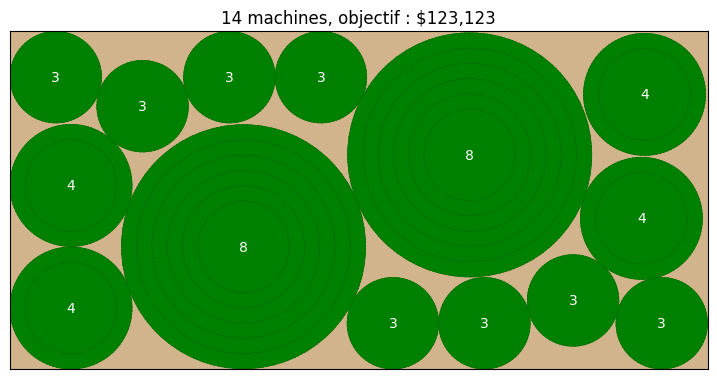

In [5]:
models = []
text = ""
for MACHINES in range(3, 15):
    model = create_model(MACHINES)
    print(f"Machines: {MACHINES}\n")
    result = solver.solve(model, tee=True)
    models.append(model)
    _, axe = plt.subplots(figsize=(9, 6))
    print_results(model, MACHINES, axe)
    plt.show()

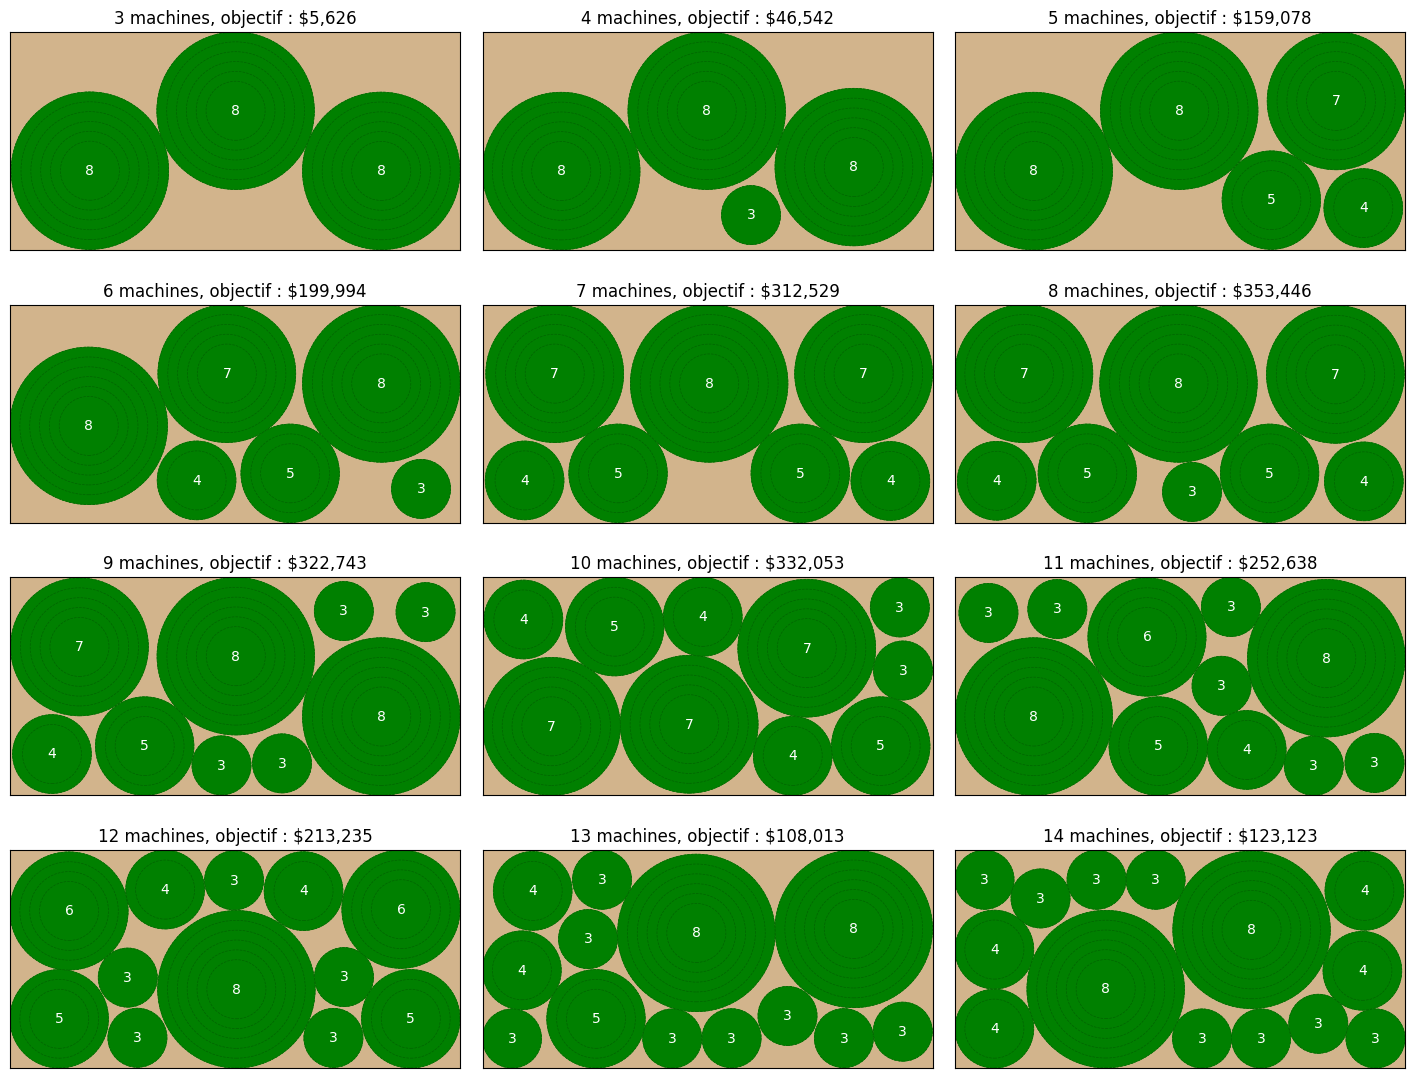

In [6]:
_, axes = plt.subplots(4, 3, figsize=(18, 14))
plt.subplots_adjust(wspace=0.05, hspace=0.05)
for MACHINES in range(3, 15):
    show_solution(
        models[MACHINES - 3], MACHINES, axes[(MACHINES - 3) // 3, (MACHINES - 3) % 3]
    )

Let's plot the results for each number of machines.

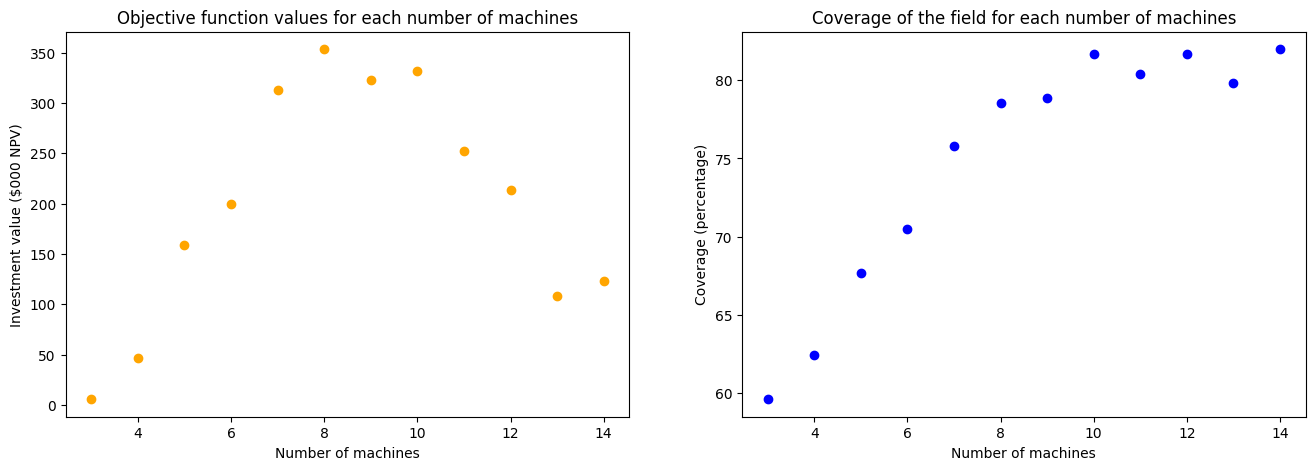

In [7]:
def calculate_coverage(model, MACHINES):
    total_area = WIDTH * LENGTH
    covered_area = sum(
        np.pi * ((model.segment[i]() * SEGMENT_LENGTH) ** 2) for i in range(MACHINES)
    )
    coverage_percentage = (covered_area / total_area) * 100
    return coverage_percentage


_, axes = plt.subplots(1, 2, figsize=(16, 5))

values = [models[i].obj() / 1000 for i in range(len(models))]
axes[0].scatter(range(3, 15), values, color="orange", label="Investment value")
axes[0].set_title("Objective function values for each number of machines")
axes[0].set_xlabel("Number of machines")
axes[0].set_ylabel("Investment value ($000 NPV)")

coverages = [calculate_coverage(models[i], i + 3) for i in range(len(models))]
axes[1].scatter(range(3, 15), coverages, color="blue")
axes[1].set_title("Coverage of the field for each number of machines")
axes[1].set_xlabel("Number of machines")
axes[1].set_ylabel("Coverage (percentage)")

plt.show()

### Conclusion

The optimal solution is to have 8 machines, with an NPV of $353,446.

Although cases with more than 8 machines cover a higher proportion of the field, they have increasingly higher initial and maintenance costs, so the extra machines are not worthwhile.

Note that, for some cases, it is possible to get higher objective function values by allowing machines with only 1 or 2 segments. But since the machines with 1 or 2 segments make a loss, it doesn't make sense to include them. Removing those loss-making machines leads to solutions with fewer machines that are uniformly worse than the solutions we've found.

